In [1]:
import torch
import sys
sys.path.append("/scratch/users/k21113539/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchviz import make_dot
from colossalai.utils import load_checkpoint
from colossalai.initialize import launch,initialize
import colossalai
from colossalai.trainer import Trainer, hooks

/users/k21113539/anaconda3/envs/cai/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
# launch('/home/viscent/hdd/viscent/SR-UNet/configs/config_vae_dhcp_dbg.py',0,1,'localhost',11451)

In [42]:
UNET = True
CKPT_DIR = "/scratch/prj/bayunet/experiments/output_unet_hcp_t1_800/0/checkpoints/33.pth"
# CKPT_DIR = "/home/viscent/hdd/viscent/SR-UNet/experiments/output_vae_dhcp_dbg/checkpoints/fold_0/10.pth"
OUTPUT_ROOT = "/media/hdd/viscent/SR-UNet/inference"
OUTPUT_PREFIX = input("UNet File prefix: ")
OUTPUT_PREFIX = os.path.join(OUTPUT_ROOT,OUTPUT_PREFIX)


if not UNET:
    model = BUNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
            latent_size=256,
            alpha=0.00025,
            )
else:
    model = UNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
    )

############# Initalize #############
# model.train()
# for x in model.modules():
#     if isinstance(x, nn.Conv3d):
#         print(x)
#         x.requires_grad_(False)
#         x.weight.fill_(0)
#####################################

# ckpt = torch.load(CKPT_DIR,map_location=torch.device('cpu'))
# # load_checkpoint(CKPT_DIR, model)
# # with torch.cuda.amp.autocast(enabled=True):
# #     if ckpt.get('model') is None:
# #         state_dict = ckpt['state_dict']
# #         _state_dict = {}
# #         for key in state_dict.keys():
# #             _state_dict[key.replace("model.","")] = state_dict[key]
# #         model.load_state_dict(_state_dict)
# #     else:
# optim = torch.optim.Adam(
#     model.parameters(),
#     lr=0.001,
#     betas=(0.9, 0.99)
# )
# model.load_state_dict(ckpt["state_dict"],strict=False)
model = torch.load(CKPT_DIR,map_location=torch.device('cpu'))
model = model.eval()

In [3]:
n_layer = 0
for layer in model.named_parameters():
    ## check require grad
    print(layer[0])
    print(layer[1].requires_grad)
    n_layer += 1
print("Total number of layers: ",n_layer)

encoders.0.basic_module.SingleConv1.groupnorm.weight
True
encoders.0.basic_module.SingleConv1.groupnorm.bias
True
encoders.0.basic_module.SingleConv1.conv.weight
True
encoders.0.basic_module.SingleConv2.groupnorm.weight
True
encoders.0.basic_module.SingleConv2.groupnorm.bias
True
encoders.0.basic_module.SingleConv2.conv.weight
True
encoders.1.basic_module.SingleConv1.groupnorm.weight
True
encoders.1.basic_module.SingleConv1.groupnorm.bias
True
encoders.1.basic_module.SingleConv1.conv.weight
True
encoders.1.basic_module.SingleConv2.groupnorm.weight
True
encoders.1.basic_module.SingleConv2.groupnorm.bias
True
encoders.1.basic_module.SingleConv2.conv.weight
True
encoders.2.basic_module.SingleConv1.groupnorm.weight
True
encoders.2.basic_module.SingleConv1.groupnorm.bias
True
encoders.2.basic_module.SingleConv1.conv.weight
True
encoders.2.basic_module.SingleConv2.groupnorm.weight
True
encoders.2.basic_module.SingleConv2.groupnorm.bias
True
encoders.2.basic_module.SingleConv2.conv.weight
Tru

In [4]:
n_layer = 0
for layer in ckpt['state_dict'].keys():
    ## check require grad
    print(layer)
    n_layer += 1
print("Total number of layers: ",n_layer)

NameError: name 'ckpt' is not defined

In [ ]:
# optim = torch.optim.Adam(
#     model.parameters(),
#     betas=(0.9, 0.99)
# )
# engine, train_dataloader, test_dataloader, lr_scheduler = colossalai.initialize(
#     model=model,
#     optimizer=optim,
#     verbose=True,)
# trainer = Trainer(engine=engine)

In [ ]:
# for k in model.state_dict().keys():
#     if ckpt['model'].get(k) is None:
#         print(k)

In [5]:
import h5py as h5
h5file = '/scratch/prj/bayunet/dhcp_lores/preprocessed_h5/sub-CC00582XX14.h5'

with h5.File(h5file,'r') as f:
    image = f['image_t1'][...].astype(np.float32)
    target = f['gt_t1'][...].astype(np.float32)
image_array = image
target_array = target
image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0)

In [ ]:
# encoder_weights = next(model.encoders[-1].parameters())
# encoder_weights = encoder_weights.cpu().detach().numpy()
# encoder_weights= np.expand_dims(encoder_weights,axis=1)
# encoder_weights = np.repeat(encoder_weights, 128, axis=1)
# if not UNET:
#     fig,(ax1,ax2) = plt.subplots(1,2)
#     im1 = ax1.imshow(encoder_weights)
#     ax1.set_title("encoder weights")
#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(im1, cax=cax, orientation="vertical")

#     latent_weights = next(model.mu.parameters())
#     latent_weights = latent_weights.cpu().detach().numpy()
#     latent_weights = np.repeat(latent_weights, 128, axis=1)

#     im2 = ax2.imshow(encoder_weights)
#     ax2.set_title("latent weights")
#     divider = make_axes_locatable(ax2)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(im2, cax=cax, orientation="vertical")
#     fig.show()
# else:
#     fig = plt.imshow(encoder_weights)
#     plt.title("encoder weights")
#     plt.colorbar()
#     plt.show()
# plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

In [ ]:
# image = sitk.ReadImage("/home/viscent/hdd/viscent/SR-UNet/experiments/output_vae_1024_t1/0/image.nii.gz")
# target = sitk.ReadImage("/home/viscent/hdd/viscent/SR-UNet/experiments/output_vae_1024_t1/0/target.nii.gz")
# image_array = sitk.GetArrayFromImage(image)
# target_array = sitk.GetArrayFromImage(target)
# image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)
# target_tensor = torch.tensor(target_array).unsqueeze(0).unsqueeze(0)

In [4]:
# with h5.File("/scratch/prj/bayunet/HCP_1200/preprocessed_h5/100206.h5","r") as f:
#     image = f['image_t1'][...].astype(np.float32)
#     target = f['gt_t1'][...].astype(np.float32)
# image_array = image
# target_array = target
# image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
# target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0)

In [ ]:
# with torch.cuda.amp.autocast(enabled=True):
# image_array = np.load("/scratch/prj/bayunet/experiments/output_vae_hcp_t1_800/0/val_image.npy")
# target_array = np.load("/scratch/prj/bayunet/experiments/output_vae_hcp_t1_800/0/val_target.npy")
# image_tensor = torch.tensor(image_array).unsqueeze(0)
# target_tensor = torch.tensor(image_array).unsqueeze(0)
# image_tensor = image_tensor.repeat(3,1,1,1,1)

In [ ]:
# image_tensor.shape

In [21]:
from dataloaders import get_synth_dhcp_dataloader, get_synth_hcp_dataloader
dataloaders, val_loader = get_synth_hcp_dataloader(data_dir="/scratch/prj/bayunet/HCP_1200",
                                                    batch_size=1,
                                                    num_samples=50,
                                                    input_modalities=["t1"],
                                                    output_modalities=["t1"],
                                                    output_dir="/scratch/prj/bayunet/HCP_1200/preprocessed_h5",
                                                    n_splits=5,
                                                    augmentation=False,
                                                    down_factor=5,)
image_tensor,target_tensor = next(iter(val_loader))


[06/07/22 02:34:51] INFO     colossalai - root - INFO: Creating dataset with 40 examples

  0%|          | 0/40 [00:00<?, ?it/s]

[06/07/22 02:34:58] INFO     colossalai - root - INFO: Creating dataset with 10 examples

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
# with torch.cuda.amp.autocast(enabled=True):
# torch.cuda.set_device(0)

# engine.train()
image_tensor,target_tensor = next(iter(val_loader))
image_tensor = image_tensor
target_tensor = target_tensor
model.zero_grad()
output = model(image_tensor)
# output = trainer.engine(image_tensor)

In [44]:
im = target_tensor
im_hat=output
mse = torch.nn.MSELoss()(im, im_hat)
print('mse:', mse.cpu().detach().numpy())
if not UNET:
    mu, logvar = model.enc_mu,model.enc_logvar
    kl = 0.5 * (logvar.exp() + mu**2 - 1 - logvar)
    kl = torch.sum(kl)
    FE_simple = mse + 0.00025 * kl
    print('kl:', kl.cpu().detach().numpy())
    print('Free energy:', FE_simple.cpu().detach().numpy())

mse: 0.036522124


In [45]:
# with torch.cuda.amp.autocast(enabled=True):
#     print(model)

In [46]:
image_array = image_tensor.cpu().detach().numpy().astype(np.float32)
target_array = target_tensor.cpu().detach().numpy().astype(np.float32)
output_array = output.cpu().detach().numpy().astype(np.float32)
output_image=sitk.GetImageFromArray(output_array)
# sitk.WriteImage(output_image,OUTPUT_PREFIX+"_output.nii.gz")

Image


Text(0.5, 1.0, 'Image')

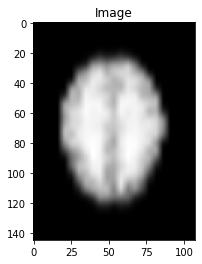

In [47]:
print("Image")
plt.imshow(image_array[0,0,image_array.shape[2]//2,...],cmap='gray')
plt.title("Image")

In [48]:
# image_tensor.shape

Output


Text(0.5, 1.0, 'Output')

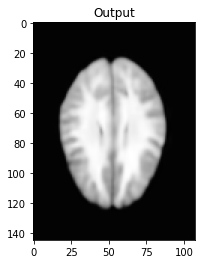

In [49]:
print("Output")
plt.imshow(output_array[0,0,output_array.shape[2]//2,...],cmap='gray')
plt.title("Output")

Target


Text(0.5, 1.0, 'Target')

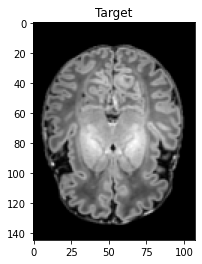

In [13]:
print("Target")
plt.imshow(target_array[0,0,target_array.shape[2]//2,...],cmap='gray')
plt.title("Target")

In [ ]:
# for encoder in model.encoders:
#     for param in encoder.parameters():
#         param.requires_grad = False
#         param.fill_(0)
# for decoder in model.decoders:
#     for param in decoder.parameters():
#         param.requires_grad = False
#         param.fill_(0)

In [ ]:
model.logvar.bias

In [ ]:
import torch.nn as nn
for x in model.modules():
    if isinstance(x, nn.Conv3d):
        print(x)
        x.requires_grad_(False)
        x.weight.fill_(0)

In [ ]:
model.train()

In [ ]:
if not UNET:
    for param in model.logvar.parameters():
        param.requires_grad = False
        param.fill_(-65535)
    output_0mu = engine(image_tensor)
    output_0mu_array = output_0mu.cpu().detach().numpy().astype(np.float32)
    output_0mu_image=sitk.GetImageFromArray(output_0mu_array)
    print("Output μ=0")
    
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0mu_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output μ=0")
else:
    for param in model.encoders[0].parameters():
        param.requires_grad = False
        param.fill_(0)
    output_0latent = model(image_tensor)
    output_0latent_array = output_0latent.cpu().detach().numpy()
    output_0latent_image=sitk.GetImageFromArray(output_0latent_array)
    print("Output latent=0")

    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0latent_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output latent=0")
plt.savefig(OUTPUT_PREFIX+"_output.png")

In [ ]:
make_dot(output,params=dict(model.named_parameters())).render(OUTPUT_PREFIX+"_structure")

In [ ]:
UNET = False
CKPT_DIR = "/media/hdd/viscent/SR-UNet/experiments/output_vae_1024_t1/checkpoints/fold_0/199.pth"
OUTPUT_ROOT = "/media/hdd/viscent/SR-UNet/inference"
OUTPUT_PREFIX = input("B-UNet File prefix: ")
OUTPUT_PREFIX = os.path.join(OUTPUT_ROOT,OUTPUT_PREFIX)

if not UNET:
    model = BUNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
            latent_size=1024,
            alpha=0.00025,
            )
else:
    model = UNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
    )
ckpt = torch.load(CKPT_DIR)
if ckpt.get('model') is None:
    state_dict = ckpt['state_dict']
    _state_dict = {}
    for key in state_dict.keys():
        _state_dict[key.replace("model.","")] = state_dict[key]
    model.load_state_dict(_state_dict)
else:
    model.load_state_dict(ckpt["model"])

In [ ]:
encoder_weights = next(model.encoders[-1].parameters())
encoder_weights = encoder_weights.cpu().detach().numpy()
encoder_weights= np.expand_dims(encoder_weights,axis=1)
encoder_weights = np.repeat(encoder_weights, 128, axis=1)
if not UNET:
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(encoder_weights)
    ax1.set_title("encoder weights")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax, orientation="vertical")

    latent_weights = next(model.mu.parameters())
    latent_weights = latent_weights.cpu().detach().numpy()
    latent_weights = np.repeat(latent_weights, 128, axis=1)

    im2 = ax2.imshow(latent_weights)
    ax2.set_title("latent weights")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax, orientation="vertical")
    fig.show()
else:
    fig = plt.imshow(encoder_weights)
    plt.title("encoder weights")
    plt.colorbar()
    plt.show()
plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

In [ ]:
image = sitk.ReadImage("/media/hdd/viscent/SynthSR/generated_data_multimodal/0008_image_t1.nii.gz")
target = sitk.ReadImage("/media/hdd/viscent/SynthSR/generated_data_multimodal/0008_target.nii.gz")
image_array = sitk.GetArrayFromImage(image)
target_array = sitk.GetArrayFromImage(target)
image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)
target_tensor = torch.tensor(target_array).unsqueeze(0).unsqueeze(0)

In [ ]:
torch.cuda.set_device(0)
model.cuda()
model.train()
image_tensor = image_tensor.cuda()
target_tensor = target_tensor.cuda()
output = model(image_tensor)


In [ ]:
im = image_tensor
im_hat=output
mse = torch.nn.MSELoss()(im, im_hat)
print('mse:', mse.cpu().detach().numpy())
if not UNET:
    mu, logvar = model.enc_mu, model.enc_logvar
    kl = 0.5 * (logvar.exp() + mu**2 - 1 - logvar)
    kl = torch.sum(kl)
    FE_simple = mse + 0.00025 * kl
    print('kl:', kl.cpu().detach().numpy())
    print('Free energy:', FE_simple.cpu().detach().numpy())

In [ ]:
output_array = output.cpu().detach().numpy()
output_image=sitk.GetImageFromArray(output_array)
sitk.WriteImage(output_image,OUTPUT_PREFIX+"_output.nii")

In [ ]:
print("Image")
plt.imshow(image_array[40,...],cmap='gray')
plt.title("Image")

In [ ]:
print("Output")
plt.imshow(output_array[0,0,40,...],cmap='gray')
plt.title("Output")

In [ ]:
print("Target")
plt.imshow(target_array[40,...],cmap='gray')
plt.title("Target")

In [ ]:
if not UNET:
    for param in model.mu.parameters():
        param.requires_grad = False
        param.fill_(0)
    output_0mu = model(image_tensor)
    output_0mu_array = output_0mu.cpu().detach().numpy()
    output_0mu_image=sitk.GetImageFromArray(output_0mu_array)
    print("Output μ=0")
    
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0mu_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output μ=0")
else:
    for param in model.encoders[0].parameters():
        param.requires_grad = False
        param.fill_(0)
    output_0latent = model(image_tensor)
    output_0latent_array = output_0latent.cpu().detach().numpy()
    output_0latent_image=sitk.GetImageFromArray(output_0latent_array)
    print("Output latent=0")

    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0latent_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output latent=0")
plt.savefig(OUTPUT_PREFIX+"_output_0.png")

In [ ]:
make_dot(output,params=dict(model.named_parameters())).render(OUTPUT_PREFIX+"_structure")